# Time Series Exercise

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import numpy pandas and matplotlib **

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

** Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month' **

In [11]:
milk = pd.read_csv("monthly-milk-production.csv", index_col="Month")

** Check out the head of the dataframe**

In [12]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [13]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6+ KB


** Make the index a time series by using: **

    milk.index = pd.to_datetime(milk.index)

In [14]:
milk.index = pd.to_datetime(milk.index)

In [15]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [16]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


** Plot out the time series data. **

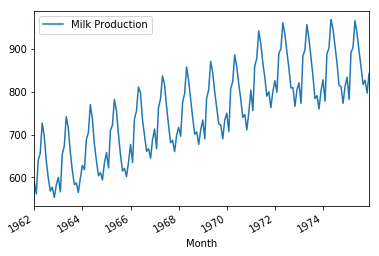

In [17]:
milk.plot()

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **

** Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 12 months of data is the test set, with everything before it is the training. **

In [18]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [19]:
train_set = milk.head(156)

In [20]:
test_set = milk.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()

In [23]:
train_scaled = scaler.fit_transform(train_set)

In [24]:
test_scaled = scaler.transform(test_set)

## Batch Function

** We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! **

In [25]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0, len(training_data)-steps) 
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN to .reshape(-1,steps,1)
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

## Setting Up The RNN Model

** Import TensorFlow **

In [26]:
import tensorflow as tf

### The Constants

** Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): **
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.03)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [27]:
# Just one feature, the time series
num_inputs = 1

# Num of steps in each batch
num_time_steps = 12

# 100 neuron layer, play with this
num_neurons = 100

# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.03 

# how many iterations to go through (training steps), you can play with this
num_train_iterations = 4000

# Size of the batch of data
batch_size = 1

** Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.**  

In [28]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

** Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (If in doubt, the solutions used an Outputprojection Wrapper around a basic LSTM cell with relu activation.**

In [29]:
lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(lstm_cell, output_size=num_outputs) 

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [30]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [31]:
outputs

<tf.Tensor 'rnn/transpose_1:0' shape=(?, 12, 1) dtype=float32>

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [32]:
y

<tf.Tensor 'Placeholder_1:0' shape=(?, 12, 1) dtype=float32>

In [33]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [34]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [35]:
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training. **

In [36]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [37]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        X_batch, y_batch = next_batch(train_scaled, batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
    
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            
    print("X_batch: ")
    print(X_batch)
    print("y_batch: ")
    print(y_batch)
        
    # Save Model for Later
    saver.save(sess, "ex_model/ex_time_series_model")

0 	MSE: 0.10124079
100 	MSE: 0.008113355
200 	MSE: 0.01069677
300 	MSE: 0.005996287
400 	MSE: 0.008126195
500 	MSE: 0.0069416463
600 	MSE: 0.0038003726
700 	MSE: 0.006440755
800 	MSE: 0.004506186
900 	MSE: 0.00656625
1000 	MSE: 0.0056187995
1100 	MSE: 0.006437201
1200 	MSE: 0.004218063
1300 	MSE: 0.003823052
1400 	MSE: 0.007576416
1500 	MSE: 0.0062479377
1600 	MSE: 0.005954212
1700 	MSE: 0.0052829343
1800 	MSE: 0.0035983503
1900 	MSE: 0.008543484
2000 	MSE: 0.0046386984
2100 	MSE: 0.005349729
2200 	MSE: 0.015127293
2300 	MSE: 0.004747912
2400 	MSE: 0.0058895666
2500 	MSE: 0.002185473
2600 	MSE: 0.00736478
2700 	MSE: 0.0065608234
2800 	MSE: 0.010508135
2900 	MSE: 0.0066214204
3000 	MSE: 0.004991498
3100 	MSE: 0.0030458712
3200 	MSE: 0.0042195893
3300 	MSE: 0.002518479
3400 	MSE: 0.005529624
3500 	MSE: 0.0033102634
3600 	MSE: 0.005841239
3700 	MSE: 0.0022210132
3800 	MSE: 0.0015057459
3900 	MSE: 0.0015572064
X_batch: 
[[[0.43990385]
  [0.30048077]
  [0.20673077]
  [0.12259615]
  [0.13942

______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [38]:
test_set

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! **

# Generative Session
### NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do! Think of this more as generating new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of our data set)
** Fill out the session code below to generate 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes. Reference the lecture for hints.**

In [39]:
# Create a numpy array for your genreative seed from the last 12 months of the 
# training set data. Hint: Just use tail(12) and then pass it to an np.array
train_seed = list(train_scaled[-12:])

In [41]:
print(train_seed)

[array([0.66105769]), array([0.54086538]), array([0.80769231]), array([0.83894231]), array([1.]), array([0.94711538]), array([0.85336538]), array([0.75480769]), array([0.62980769]), array([0.62259615]), array([0.52884615]), array([0.625])]


In [42]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "ex_model/ex_time_series_model")

    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ex_model/ex_time_series_model


** Show the result of the predictions. **

In [43]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.6807785,
 0.5222652,
 0.8789622,
 0.91001064,
 1.1644938,
 1.0611682,
 1.0256633,
 0.9816058,
 0.87611234,
 0.8260477,
 0.7120718,
 0.79500127]

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [44]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [45]:
results.shape

(12, 1)

In [46]:
results

array([[ 836.20386],
       [ 770.2623 ],
       [ 918.6483 ],
       [ 931.5644 ],
       [1037.4294 ],
       [ 994.4459 ],
       [ 979.67596],
       [ 961.34796],
       [ 917.46277],
       [ 896.6358 ],
       [ 849.22186],
       [ 883.7205 ]], dtype=float32)

** Create a new column on the test_set called "Generated" and set it equal to the generated results. You may get a warning about this, feel free to ignore it.**

In [47]:
test_set['Generated'] = results

C:\Users\Soroosh-PC\.conda\envs\KerasCPU\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** View the test_set dataframe. **

In [48]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,836.203857
1975-02-01 01:00:00,782.0,770.262329
1975-03-01 01:00:00,892.0,918.648315
1975-04-01 01:00:00,903.0,931.564392
1975-05-01 01:00:00,966.0,1037.429443
1975-06-01 01:00:00,937.0,994.445923
1975-07-01 01:00:00,896.0,979.675964
1975-08-01 01:00:00,858.0,961.347961
1975-09-01 01:00:00,817.0,917.462769


** Plot out the two columns for comparison. **

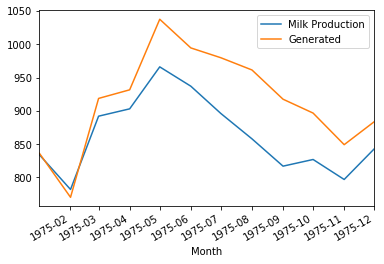

In [49]:
test_set.plot()

Play around with the parameters and RNN layers, does a faster learning rate with more steps improve the model? What about GRU or BasicRNN units? What if you train the original model to not just predict one timestep ahead into the future, but 3 instead? Lots of stuff to add on here!